# Notebook 6: Generative Adversarial Networks

In this notebook we'll explore __Generative Adversarial Networks (GANs)__, a popular class of generative models developed in the past decade. Recall that in the previous notebook, we explored ways in which we could fool a fixed neural network classifier by optimizing its inputs. More specifically, we used the gradients of the classifier to craft perturbations in the input space that resulted in predictions of a chosen class. While our perturbations were small and somewhat noisy, one might wonder: _under certain conditions, might a gradient-guided perturbation actually cause an input to resemble an instance of the chosen class?_ Taking this idea to an extreme, we might start with random noise as an input and keep applying perturbations until we maximize the score of a particular class. Could we wind up with a "realistic" instance of that class?

This generally isn't the case with additive perturbations like those seen in the previous notebook; however, a very similar idea is at the core of GANs. In this notebook, we will show how simultaneously training two "competing" neural networks can allow us to produce synthetic instances that closely resemble an actual dataset. We'll start with a simple GAN architecture and the MNIST dataset to generate synthetic digits.

The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [What Are GANs?](#intro)  
     2.1 [Theory and Motivation](#theory)  
     2.2 [A Simple MLP Architecture](#mlp)  
     2.3 [Generating Synthetic Digits](#mnist)  
     2.4 [Exploring the Latent Space](#latent)  

## __1.__ <a name="setup">Setup</a>


In [1]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt

Cloning into 'course-deep-learning'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 493 (delta 64), reused 67 (delta 28), pack-reused 379
Receiving objects: 100% (493/493), 141.72 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Updating files: 100% (61/61), done.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using 

In [2]:
%matplotlib inline
%cd course-deep-learning/

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

/content/course-deep-learning


## __2.__ <a name="intro">What Are GANs?</a>

In this section, we'll introduce the general GAN architecture and implement a specific variant to generate synthetic digits. This tutorial is necessarily brief, but if you want to dive in deeper feel free to check out these resources:
* [GAN-MNIST-PyTorch](https://github.com/jsuarez5341/GAN-MNIST-Pytorch)
* [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* [How to Identify and Diagnose GAN Failure Modes](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/)

### __2.1__ <a name="theory">Theory and Motivation</a>
A generative adversarial network consists of two networks: a __generator__ and a __discriminator__. The generator network $G$ attempts to map samples $z$ from a noise distribution $p_z$ to instances of a dataset. The discriminator network $D$ attempts to distinguish between generated samples $G(z)$ and actual samples from the dataset $x \sim p_x$. These networks are trained in tandem:
* Samples are drawn from the dataset $x \sim p_x$
* Samples are drawn from the noise distribution $z \sim p_z$ and passed to the generator to create synthetic instances $G(z)$
* For each sample $x$ drawn from the data set, the discriminator returns, $D(x)$, its estimate of the probability that $x$ is a true example.
* For each synthetic example $G(z)$, the discriminator  returns $D(G(z))$, its estimate of the probability $G(z)$ is a true example.

We can visualize the discriminator update step as follows:

<center>
<img width="600px" src="https://drive.google.com/uc?export=view&id=1qvATu5c2W27nNfECj2hdv5Mmr0qlguC7"/>
</center>

Similarly, we can visualize the generator update step:

<br/>
<center>
<img width="600px" src="https://drive.google.com/uc?export=view&id=1ut3neg4FJ6pQBgH9jRDjAQhpD3N4xzml"/>
</center>

At this point, the generator and discriminator have competing objectives: the generator succeeds in creating "realistic" samples when $D(G(z))$ is high, and the discriminator succeeds in distinguishing samples when $D(G(z))$ is low and $D(x)$ is high. The theory behind GANs is that when we allow the networks to optimize these competing objectives, they will converge to an equilibrium in which the generator produces high-quality samples that the discriminator cannot distinguish from real data. In their paper introducing GANs,
[Goodfellow et al. (2014)](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf) formulate this adversarial optimization as follows:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_x} \left[\log D(x) \right] + \mathbb{E}_{z \sim p_z} \left[\log \left(1 - D\left(G(z)\right)\right) \right]$$

While this minimax objective looks tricky to deal with, in practice we can avoid its nested dependencies by simply optimizing the generator and discriminator in turns. Even better, we can express the objectives of the generator and discriminator using PyTorch's built-in __binary cross-entropy loss__. For a target $y \in \{0, 1\}$ and prediction $y' \in [0, 1]$, the binary cross-entropy loss is defined as

$$\mathrm{BCE}(y, y') = - \left[ y \cdot \log y' + (1 - y) \cdot \log(1 - y') \right]$$

Given a batch of real data $x$ and synthetic data $G(z)$, let's start by training the discriminator. We'll set $y = 1$ for every real example $x$. We'll set $y = 0$ for every generated example $G(z)$. We will take the output of our discriminator $D$ as our prediction $y'$. Plugging this into our BCE loss function, our discriminator loss becomes:

$$
\begin{align*}
\mathrm{BCE}_{\mathrm{total}} &= \mathrm{BCE}_{\mathrm{real}} + \mathrm{BCE}_{\mathrm{generated}} \\
 &= \mathrm{BCE}(1, D(x)) + \mathrm{BCE}(0, D(G(z))) \\
 &= -\left[1 \cdot \log D(x) + 0 \cdot \log(1 - D(x))\right] - \left[0 \cdot \log D(G(z)) + 1 \cdot \log(1 - D(G(z)))\right] \\
 &= -\log D(x) - \log(1 - D(G(z)))
\end{align*}
$$

Note that this rewards a high $D(x)$ and penalizes a high $D(G(z))$, aligning with the discriminator's objective. Once we've performed a training step with the discriminator, we can do the same with the generator, this time using the "real" label $y = 1$ as our target for the discriminator's output:

$$
\begin{align*}
\mathrm{BCE}_{\mathrm{total}} &= \mathrm{BCE}_{\mathrm{generated}} \\
 &= \mathrm{BCE}(1, D(G(z))) \\
 &= -\left[1 \cdot \log D(G(z)) + 0 \cdot \log(1 - D(G(z)))\right]\\
 &= -\log D(G(z))
\end{align*}
$$

This rewards a high $D(G(z))$, aligning with the generator's objective. Note, too, that this loss function does not consider real examples $x$. This is because this loss is applied to the generator, which is only concerned with generating fake examples.

That's GAN training in a nutshell -- we'll simply compute a cross-entropy loss for the discriminator and then the generator at every iteration, followed by a gradient-based update to the weights of each model. We'll start with a simple architecture for our generator and discriminator networks, and train on the MNIST dataset to produce synthetic digits.

### __2.2__ <a name="mlp">A Simple MLP Architecture</a>

Our generator and discriminator networks will be simple multi-layer perceptrons. The generator network will map latents (random Gaussian noise) to a vector of size 784 (the number of pixels in an MNIST image). The discriminator will map MNIST images (flattened to 784-dimensional vectors) to a scalar probability that the image is real. To ensure stability, we will use the same number of layers and layer dimensions in both networks.

Note the use of [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) and [`LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activation functions. The choice of activation functions in a network is an important but often-overlooked part of the design process, as it can effect how (or even _whether_) gradients flow. For example, `LeakyReLU` uses a small nonzero slope for negative inputs, resulting nonzero gradients where `ReLU` and `Sigmoid` would have exactly or nearly zero slope. To see the impact of this choice when we eventually train our network, you could try substituting in the `torch.nn.Sigmoid` activation function. You may find that our GAN's output completely collapses to seemingly random noise!

In [3]:
class MLPGenerator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPDiscriminator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Discriminator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]  # final output is scalar (probability)

        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPGAN(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 latent_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        """Construct a simple MLP generative adversarial network

        number_of_hidden_layers: An int. Must be >=0. Defines the number of
                hidden layers for both the discriminator D and generator G
        latent_size:  An int. Defines the size of the random input vector z
                passed to the generator to make the fake example G(z)
        hidden_size: An int. The size of each hidden layer for the discriminator
                D and the generator G.
        output_size: An int. Determines the size of the output generated by the
                discriminator. It should match the size of a real example.
        activation_generator: A torch.nn.Module defining the activation function
                in every hidden layer of the generator.
        activation_discriminator: A torch.nn.Module defining the activation function
                in every hidden layer of the discriminator.
        """
        super().__init__()

        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=latent_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation=activation_generator
        )

        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            activation=activation_discriminator
        )

### __2.3__ <a name="mnist">Generating Synthetic Digits</a>

Now it's time to train our GAN! As discussed above, we'll alternate between updating the generator and discriminator networks. To keep track of training progress, we'll use TensorBoard (see Notebook 3).

#### Training Configuration

To view progress after starting your training loop below, you may need to refresh Tensorboard (an icon should appear in the top-right corner of the following cell).

In [12]:
# here, we'll initialize TensorBoard. You should see an empty window in this cell, which will populate with
# graphs as soon as we run our training code below.
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1347), started 0:51:33 ago. (Use '!kill 1347' to kill it.)

<IPython.core.display.Javascript object>

In [5]:
# GAN training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.0002
epochs = 80

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
gan = MLPGAN(
    number_of_hidden_layers=number_of_hidden_layers,
    latent_size=latent_size,
    hidden_size=hidden_size,
    output_size=image_size*image_size,
).to(device)

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(gan.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(gan.generator.parameters(), lr=lr)

# loss function: binary cross-entropy loss
loss = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latent vectors z that we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
!rm -rf ./logs/

# timestamp the logs for each run so we can sort through them
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

# plot example training images
batch, _ = next(iter(mnist))
logger.add_image("training_images", make_grid(batch, math.floor(math.sqrt(batch_size))), 0)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 11438305.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 357822.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3214117.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 10410125.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


#### Training Loop

We're ready to train! Check out the TensorBoard cell above to view training results in real time (you may need to periodically refresh using the icon in the upper right corner). If you're using Google Colab with a GPU enabled, training through all 80 epochs should take around twenty minutes.

In [6]:
# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
score_real = np.zeros(epochs)
score_fake = np.zeros(epochs)

for epoch in range(epochs):

    # weight batch losses/scores proportional to batch size
    iter_count = 0

    for batch_idx, batch_data in enumerate(mnist):

        # we only care about inputs, not labels
        x_real, _ = batch_data

        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################

        gan.discriminator.zero_grad()

        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = gan.discriminator(x_real)
        loss_real = loss(preds_real, y_real)

        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = gan.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = gan.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = loss(preds_fake, y_fake)

        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()

        ########################################################################
        # STEP 2: train the generator network to minimize the objective
        #         log(1 - D(G(z))), or equivalently, to maximize D(G(z))
        ########################################################################

        gan.generator.zero_grad()

        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = gan.generator(z)
        preds_fake = gan.discriminator(x_fake)
        loss_generator = loss(preds_fake, y_real)
        loss_generator.backward()

        # update generator weights
        opt_generator.step()

        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        score_real[epoch] += preds_real.mean().detach().item() * n_batch
        score_fake[epoch] += preds_fake.mean().detach().item() * n_batch

        iter_count += n_batch

    # plot generator and discriminator losses
    loss_d[epoch] /= iter_count
    loss_g[epoch] /= iter_count
    logger.add_image("training_loss", make_loss_plot(epochs, loss_d, loss_g), epoch)

    # plot discriminator scores
    score_real[epoch] /= iter_count
    score_fake[epoch] /= iter_count
    logger.add_image("discriminator_scores", make_score_plot(epochs, score_real, score_fake), epoch)

    # plot example generated images
    with torch.no_grad():
        generated = gan.generator(fixed_latents).reshape(batch_size, 1, image_size, image_size)
        logger.add_image("generated_images", make_grid(generated, math.floor(math.sqrt(batch_size)), title="Generated Images"), epoch)

    if not epoch % 10:
        print(f"Epoch: {epoch + 1}\tDiscriminator Loss: {loss_d[epoch] :0.4f}\tGenerator Loss: {loss_g[epoch] :0.4f}")

Epoch: 1	Discriminator Loss: 0.1538	Generator Loss: 5.0902
Epoch: 11	Discriminator Loss: 0.0344	Generator Loss: 8.3212
Epoch: 21	Discriminator Loss: 0.1765	Generator Loss: 5.1084
Epoch: 31	Discriminator Loss: 0.5473	Generator Loss: 2.5015
Epoch: 41	Discriminator Loss: 0.6612	Generator Loss: 2.0521
Epoch: 51	Discriminator Loss: 0.7002	Generator Loss: 1.9090
Epoch: 61	Discriminator Loss: 0.7138	Generator Loss: 1.8572
Epoch: 71	Discriminator Loss: 0.7175	Generator Loss: 1.8265


### __2.4__ <a name="latent">Exploring the Latent Space</a>

We've got a GAN! Our network is now trained to map standard Gaussian noise to MNIST-style digits! To see for yourself, try running the cell below a few times:

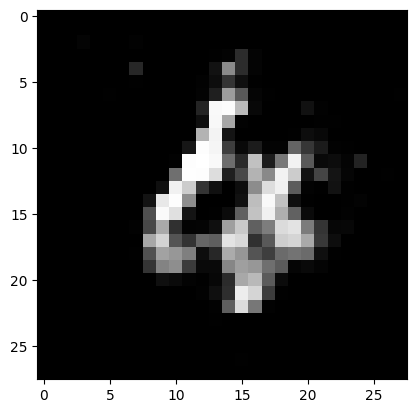

In [14]:
z = torch.randn(1, latent_size).to(device)
output = gan.generator(z).reshape(image_size, image_size)
plt.imshow(output.detach().cpu().numpy(), cmap='gray')
plt.show()

Because our GAN has learned to map high-likelihood points under our latent distribution to realistic digits, we can do lots of cool things -- for example, smoothly interpolating between digits by traversing the latent space. The code below will generate a video file `latent_walk.mp4`

In [8]:
%%capture

fig = plt.figure()

# the number of steps we will take between two latent points
n_steps = 20

# randomly sample two points from the latent distribution
point1 = torch.randn(1, latent_size).to(device)
point2 = torch.randn(1, latent_size).to(device)

# initial plot
img = gan.generator(point1).view(28, 28)
im = plt.imshow(img.detach().cpu().numpy(), cmap='gray')

def init():
    im.set_data(gan.generator(point1).view(28, 28).detach().cpu().numpy())
    return [im]

def animate(i):
    # interpolate between points in the latent space and pass through the generator
    point = (i/n_steps) * (point2 - point1) + point1
    img = gan.generator(point).view(28, 28)
    im.set_array(img.detach().cpu().numpy())
    return [im]

# create an animation and save
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=30, blit=True)
anim.save('latent_walk.mp4', fps=30)

You can view the video locally, or run the code below to display it in a notebook cell:

In [9]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('latent_walk.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

We can also put our adversarial example knowledge from Notebook 5 to use, and optimize an input to our generator such that the generated image is close to an actual image from the MNIST dataset! To see how, we'll start with a random MNIST image:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


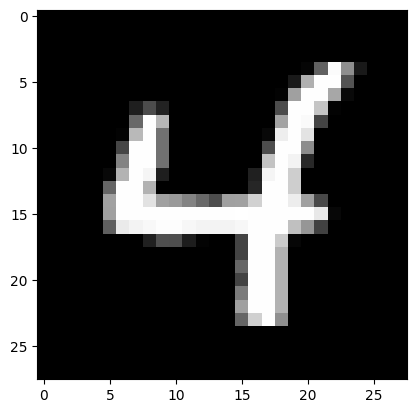

In [10]:
batch, labels = next(iter(mnist))
example_img, example_label = batch[0], labels[0]
plt.imshow(example_img.reshape(image_size, image_size), cmap='gray')
plt.show()

This will be our "target," i.e. what we want to steer our generator's output towards. To do this, we need a loss function to penalize the "distance" between our generator's output and the example image. One option is to simply use the mean squared error between a generated image and our example. This is a pretty rough metric, and so it may take a few tries to find an image that looks like our example. We'll use the same basic "adversarial" loop as in Notebook 4, optimizing an additive perturbation of a latent (noise) vector that will be passed through the generator until its output matches our example image.

MSE Loss: 121.7787
MSE Loss: 31.2914
MSE Loss: 28.1018
MSE Loss: 31.6928
MSE Loss: 27.2321
MSE Loss: 27.2167
MSE Loss: 26.5607
MSE Loss: 26.1104
MSE Loss: 26.3708
MSE Loss: 25.0795


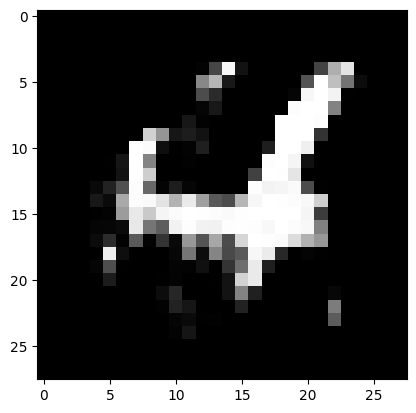

In [11]:
# optimize a latent vector such that when passing it through the generator, the output looks like out image
z = torch.randn(1, latent_size).to(device).requires_grad_(True)

for i in range(10000):

    z.grad = None

    output = gan.generator(z)

    matching_loss = torch.square(output.reshape(-1) - example_img.reshape(-1).to(device)).sum()
    matching_loss.backward()

    grad = z.grad.detach()

    with torch.no_grad():
        z -= grad/grad.norm().item()

    # plot generated image
    if not i % 1000:
        print(f"MSE Loss: {matching_loss.item() :0.4f}")
        #plt.imshow(output.detach().cpu().reshape(image_size, image_size), cmap='gray')
        #plt.show()

plt.imshow(output.detach().cpu().reshape(image_size, image_size), cmap='gray')
plt.show()

And that's it for our basic GAN!